# 02 - Parks pro Bezirk

**Ziel:** Ermittelt Parkindikatoren pro Stadtbezirk auf OSM-Basis.

**Inputs:** data/interim/muc_bezirke_bev_clean.geojson, OSM-Parks

**Outputs:** data/processed/muc_bezirke_parks.geojson

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup

In diesem Abschnitt werden Bibliotheken, Pfade und Arbeitsverzeichnisse definiert. Damit ist sichergestellt, dass alle folgenden Schritte reproduzierbar auf denselben Datenpfaden laufen.

In [84]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
INTERIM_DIR = BASE_DIR / "data" / "interim"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
# Standardisierte Output-Ordner fuer Notebook 02
OUTPUT_DIR = BASE_DIR / "outputs"
FIG_DIR = OUTPUT_DIR / "figures" / "02_parks"
TABLE_DIR = OUTPUT_DIR / "tables" / "02_parks"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
INTERIM_DIR, PROCESSED_DIR


(PosixPath('../data/interim'), PosixPath('../data/processed'))

## Datenbasis

In diesem Abschnitt werden die Bezirksgrundlage und die OSM-Parkdaten geladen und auf Kompatibilität geprüft. Ziel ist eine konsistente räumliche Ausgangsbasis für die Kennzahlenbildung.

### Bezirk DF laden

In diesem Abschnitt wird der bereinigte Bezirksdatensatz aus Notebook 01 eingelesen. Er stellt die Referenzgeometrie für alle späteren Parkindikatoren auf Bezirksebene dar.

In [85]:
gdf_bezirke = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bezirke.head()


,bez_nr,name,stadtbezirk,einwohner,flaeche_ha,einwohnerdichte,geometry
0,1,Altstadt-Lehel,Altstadt - Lehel,20876,314.59,66.0,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,Ludwigsvorstadt - Isarvorstadt,50081,440.17,114.0,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,Maxvorstadt,52434,429.82,122.0,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,Schwabing West,68610,436.33,157.0,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,Au - Haidhausen,63972,422.00,152.0,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


### Parks aus OpenStreetMap laden

In diesem Abschnitt werden OSM-Parks für München geladen und in das CRS der Bezirke transformiert. Dadurch sind Overlay-Operationen und flächenbasierte Kennzahlen methodisch sauber möglich.

In diesem Schritt werden alle OSM-Objekte mit `leisure = "park"` für das Stadtgebiet
München abgefragt und in das gleiche Koordinatensystem wie der Bezirkslayer transformiert.

In [86]:
place_name = "München, Deutschland"
park_tags = {"leisure": "park"}

# Parks aus OSM abfragen
gdf_parks = ox.features_from_place(place_name, park_tags)

# CRS an Bezirkslayer anpassen
gdf_parks = gdf_parks.to_crs(gdf_bezirke.crs)

gdf_parks[["name", "geometry"]].head()
len(gdf_parks)


954

**Erkenntnisse:**
- Die OSM-Parkdaten decken das gesamte Stadtgebiet ab und sind als Geometrien direkt auswertbar.
- Durch die CRS-Angleichung sind räumliche Schnittmengen zwischen Parks und Bezirken technisch valide.
- Für den Bericht wichtig: Die Datenquelle ist offen und nachvollziehbar, aber OSM-typisch in der Erfassungsqualität heterogen.

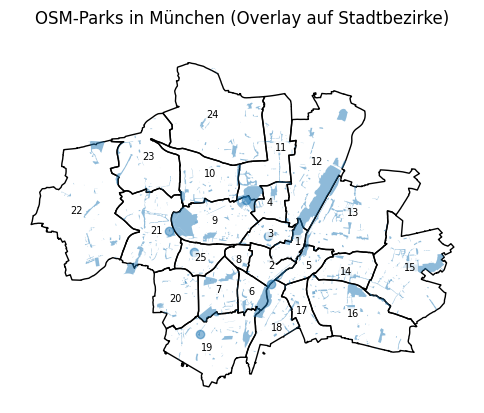

In [87]:
# Visualisierung der Parks über den Stadtbezirken
ax = gdf_bezirke.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
gdf_parks.plot(ax=ax, alpha=0.5)
# Bezirksnummern einzeichnen (robust für unterschiedliche Spaltennamen)
label_col = "sb_nummer" if "sb_nummer" in gdf_bezirke.columns else "bez_nr"
label_points = gdf_bezirke.geometry.representative_point()
for x, y, sb in zip(label_points.x, label_points.y, gdf_bezirke[label_col]):
    ax.text(
        x,
        y,
        str(sb),
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        bbox=dict(
            facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.12"
        ),
    )
plt.title("OSM-Parks in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.savefig(FIG_DIR / "01_overlay_parks_bezirke.png", dpi=180, bbox_inches="tight")
plt.show()


**Erkenntnisse:**
- Die Overlay-Karte zeigt, dass Parkobjekte räumlich nicht gleichmäßig verteilt sind: größere zusammenhängende Parkstrukturen liegen eher in flächenstarken Rand- und Mischbezirken.
- Innenstadtnähere Bezirke wirken dagegen kleinteiliger und stärker fragmentiert, was auf eine andere Form der Grünversorgung (viele kleine statt wenige große Flächen) hindeutet.
- Für den Bericht: Bereits die visuelle Verteilung legt nahe, dass absolute Fläche und wohnortnahe Erreichbarkeit getrennt bewertet werden sollten.
- Methodisch stützt die Karte die Datenplausibilität (Parks liegen in erwartbaren städtischen Räumen und nicht systematisch außerhalb der Bezirkskulisse).

## Datenaufbereitung

In diesem Abschnitt werden Parks flächenanteilig den Bezirken zugeordnet und anschließend zu Kennzahlen aggregiert. So entsteht ein belastbarer Vergleichsdatensatz je Bezirk.

### Räumliche Zuordnung der Parks zu Stadtbezirken

In diesem Abschnitt werden Parkgeometrien flächenanteilig den Bezirken zugeordnet. Damit werden Grenz- und Überlappungseffekte methodisch sauber behandelt.

Mittels `gpd.overlay(..., how="intersection")` werden Parks auf Bezirksflächen zugeschnitten. Jeder Flächenanteil wird eindeutig einem Bezirk (`bez_nr`) zugeordnet, wodurch Doppelzählungen an Grenzen vermieden werden.

### Aggregation auf Bezirksebene & Ableitung von Park-Kennzahlen

In diesem Abschnitt werden absolute und normierte Parkkennzahlen abgeleitet. Dadurch werden Bezirke trotz unterschiedlicher Fläche und Bevölkerungsgröße fair vergleichbar.

In [88]:
# Nur Polygone behalten, damit eine flaechenbasierte Zuordnung zu Bezirken moeglich ist
parks = (
    gdf_parks[gdf_parks.geometry.geom_type.isin(["Polygon", "MultiPolygon"])][
        ["name", "geometry"]
    ]
    .copy()
    .reset_index(drop=True)
)

# Eindeutige Park-ID fuer stabile Zaehlungen
parks["park_id"] = parks.index.astype(int)

# Flaechenanteilige Zuordnung: Parks mit Bezirken schneiden
parks_in_bezirke = gpd.overlay(
    parks[["park_id", "name", "geometry"]],
    gdf_bezirke[["bez_nr", "geometry"]],
    how="intersection",
)

# Teilflaechen in m2
parks_in_bezirke["park_area_m2"] = parks_in_bezirke.geometry.area

parks_in_bezirke[["park_id", "name", "bez_nr", "park_area_m2"]].head(10)


,park_id,name,bez_nr,park_area_m2
0,0,Weißenseepark,17,64388.083339
1,1,Hinterbrühler Park,19,373986.542046
2,2,NaN,15,109473.729403
3,3,NaN,21,4745.324016
4,4,Am Durchblick,21,302687.859111
5,5,NaN,21,96154.381398
6,5,NaN,23,37554.020730
7,6,NaN,16,27194.643780
8,7,NaN,16,15816.012280
9,8,NaN,8,10600.725863


In [89]:
# Anzahl Parks je Bezirk (ein Park zaehlt je Bezirk maximal einmal)
parks_per_bez = (
    parks_in_bezirke.groupby("bez_nr")["park_id"]
    .nunique()
    .reset_index(name="parks_count")
)

# Ueberlappungsbereinigte Parkflaeche je Bezirk
# 1) Parkflaechen zu nicht-ueberlappender Maske vereinen
parks_union_geom = parks.geometry.union_all()
parks_union = gpd.GeoDataFrame(geometry=[parks_union_geom], crs=parks.crs).explode(
    index_parts=False
)
parks_union = parks_union[~parks_union.geometry.is_empty].copy()

# 2) Vereinigte Flaechenmaske mit Bezirken schneiden
parks_union_in_bezirke = gpd.overlay(
    parks_union[["geometry"]], gdf_bezirke[["bez_nr", "geometry"]], how="intersection"
)
parks_union_in_bezirke["park_area_m2"] = parks_union_in_bezirke.geometry.area

# 3) Flaeche je Bezirk aggregieren
parks_area_per_bez = (
    parks_union_in_bezirke.groupby("bez_nr")["park_area_m2"].sum().reset_index()
)
parks_area_per_bez["parks_area_ha"] = parks_area_per_bez["park_area_m2"] / 10_000
parks_area_per_bez = parks_area_per_bez[["bez_nr", "parks_area_ha"]]


In [90]:
# Mit Bezirksdaten zusammenfuehren
gdf_active = gdf_bezirke.merge(parks_per_bez, on="bez_nr", how="left")
gdf_active = gdf_active.merge(parks_area_per_bez, on="bez_nr", how="left")

# Bezirke ohne Parks auf 0 setzen
gdf_active[["parks_count", "parks_area_ha"]] = gdf_active[
    ["parks_count", "parks_area_ha"]
].fillna(0)

# Kennzahlen ableiten
gdf_active["parks_pro_1000_einw"] = (
    gdf_active["parks_count"] / gdf_active["einwohner"] * 1000
)
gdf_active["parks_area_ha_pro_1000_einw"] = (
    gdf_active["parks_area_ha"] / gdf_active["einwohner"] * 1000
)
gdf_active["parks_area_anteil_prozent"] = (
    gdf_active["parks_area_ha"] / gdf_active["flaeche_ha"] * 100
)

# Ergebnis pruefen
gdf_active[
    [
        "bez_nr",
        "name",
        "parks_count",
        "parks_area_ha",
        "parks_pro_1000_einw",
        "parks_area_anteil_prozent",
    ]
].head(30)


,bez_nr,name,parks_count,parks_area_ha,parks_pro_1000_einw,parks_area_anteil_prozent
0,1,Altstadt-Lehel,27,81.228382,1.293351,25.820395
1,2,Ludwigsvorstadt-Isarvorstadt,21,21.186172,0.419321,4.813179
2,3,Maxvorstadt,34,30.975038,0.648434,7.206514
3,4,Schwabing-West,23,49.039401,0.335228,11.239062
4,5,Au-Haidhausen,36,44.414383,0.562746,10.524735
5,6,Sendling,19,94.753146,0.463392,24.055738
6,7,Sendling-Westpark,35,134.750102,0.562339,17.242716
7,8,Schwanthalerhöhe,10,11.762396,0.348626,5.681493
8,9,Neuhausen-Nymphenburg,75,338.813473,0.736008,26.234309
9,10,Moosach,45,74.805525,0.803356,6.743064


**Erkenntnisse:**
- Der finale Datensatz liegt vollständig auf Bezirksebene vor und enthält alle für den Bericht relevanten Parkindikatoren.
- Absolute und normierte Kennzahlen sind gemeinsam verfügbar und erlauben sowohl Struktur- als auch Gerechtigkeitsvergleiche.
- Die Datenbasis ist damit direkt für Indexbildung und politische Einordnung nutzbar.

## Explorative Analyse der Kennzahlen

In diesem Abschnitt werden die Kennzahlen tabellarisch und grafisch interpretiert. Ziel ist es, Unterschiede zwischen Bezirken fachlich einzuordnen und für den Bericht argumentativ nutzbar zu machen.

In [91]:
parks_table = gdf_active[
    [
        "bez_nr",
        "name",
        "parks_count",
        "parks_area_ha",
        "parks_pro_1000_einw",
        "parks_area_anteil_prozent",
    ]
].copy()
parks_table.to_csv(
    TABLE_DIR / "01_parks_kennzahlen_bezirke.csv", index=False, float_format="%.4f"
)
parks_table.head(30)


,bez_nr,name,parks_count,parks_area_ha,parks_pro_1000_einw,parks_area_anteil_prozent
0,1,Altstadt-Lehel,27,81.228382,1.293351,25.820395
1,2,Ludwigsvorstadt-Isarvorstadt,21,21.186172,0.419321,4.813179
2,3,Maxvorstadt,34,30.975038,0.648434,7.206514
3,4,Schwabing-West,23,49.039401,0.335228,11.239062
4,5,Au-Haidhausen,36,44.414383,0.562746,10.524735
5,6,Sendling,19,94.753146,0.463392,24.055738
6,7,Sendling-Westpark,35,134.750102,0.562339,17.242716
7,8,Schwanthalerhöhe,10,11.762396,0.348626,5.681493
8,9,Neuhausen-Nymphenburg,75,338.813473,0.736008,26.234309
9,10,Moosach,45,74.805525,0.803356,6.743064


**Erkenntnisse:**
- Die Tabelle bestätigt das vollständige Kennzahlenset je Bezirk (`parks_count`, `parks_area_ha`, normierte Kennzahlen).
- Für die Berichtslogik ist wichtig: Es sind sowohl Mengen- als auch Flächenperspektive enthalten.
- Damit lassen sich Versorgungslücken nicht nur absolut, sondern auch relativ zur Bevölkerung diskutieren.

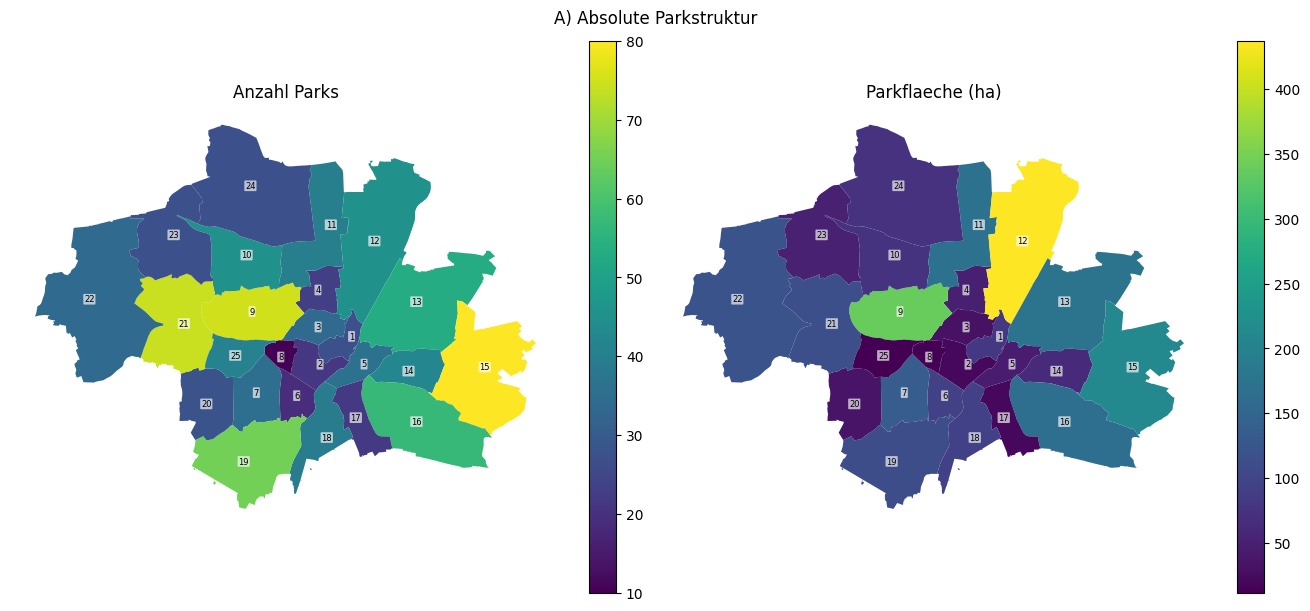

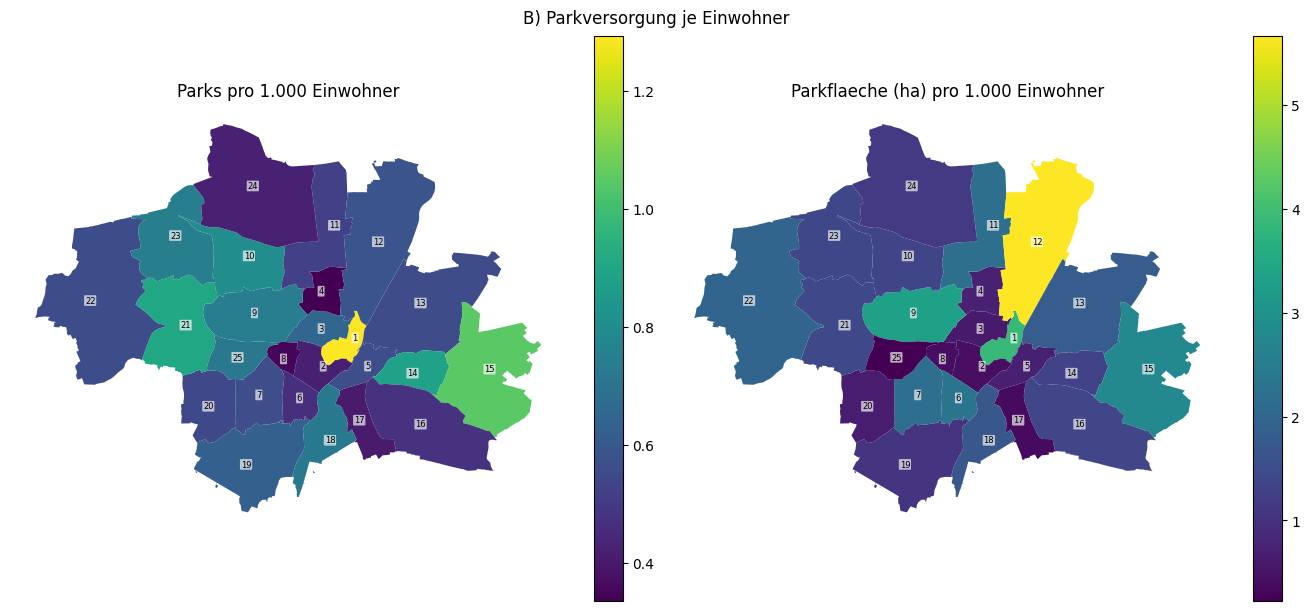

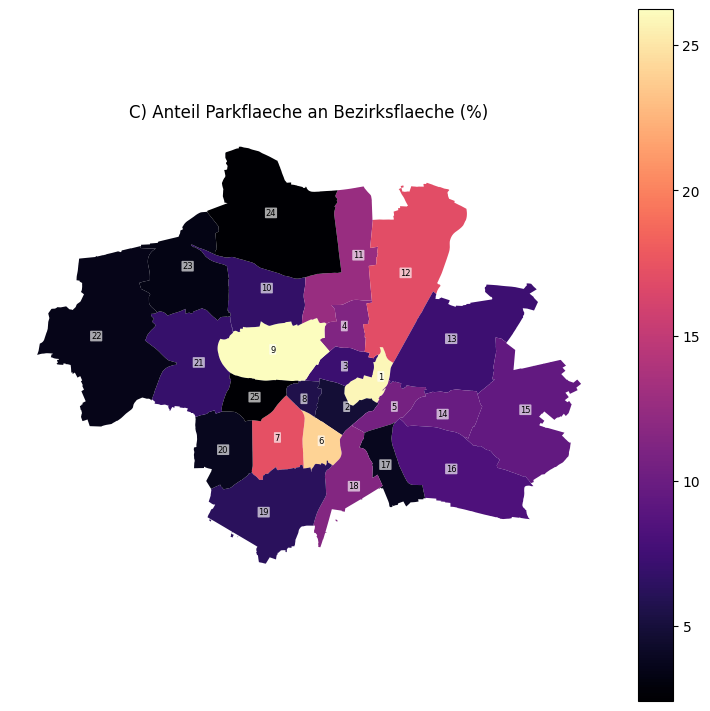

In [92]:
# Choroplethenkarten thematisch gruppiert
# Gruppe A: Absolute Parkstruktur
# Gruppe B: Versorgungskennzahlen (pro 1.000 Einwohner)
# Gruppe C: Flaechenanteil als separater Fokusindikator
# Bezirksnummern vorbereiten (robust fuer unterschiedliche Spaltennamen)
label_col = "sb_nummer" if "sb_nummer" in gdf_active.columns else "bez_nr"
label_points = gdf_active.geometry.representative_point()


def _plot_pair(df, cols_titles, fig_title, cmap="viridis"):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6), constrained_layout=True)
    for ax, (col, title) in zip(axes, cols_titles):
        df.plot(column=col, legend=True, ax=ax, cmap=cmap)
        for x, y, sb in zip(label_points.x, label_points.y, df[label_col]):
            ax.text(
                x,
                y,
                str(sb),
                fontsize=6,
                ha="center",
                va="center",
                color="black",
                bbox=dict(
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.65,
                    boxstyle="round,pad=0.10",
                ),
            )
        ax.set_title(title)
        ax.axis("off")
    fig.suptitle(fig_title, fontsize=12)
    # Dateiname anhand des Titels robust erzeugen
    slug = (
        fig_title.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace("(", "")
        .replace(")", "")
    )
    plt.savefig(FIG_DIR / f"02_{slug}.png", dpi=180, bbox_inches="tight")
    plt.show()


# A) Absolute Strukturkennzahlen nebeneinander
_plot_pair(
    gdf_active,
    [
        ("parks_count", "Anzahl Parks"),
        ("parks_area_ha", "Parkflaeche (ha)"),
    ],
    "A) Absolute Parkstruktur",
)
# B) Versorgungskennzahlen nebeneinander
_plot_pair(
    gdf_active,
    [
        ("parks_pro_1000_einw", "Parks pro 1.000 Einwohner"),
        ("parks_area_ha_pro_1000_einw", "Parkflaeche (ha) pro 1.000 Einwohner"),
    ],
    "B) Parkversorgung je Einwohner",
)
# C) Flaechenanteil als separater Fokusindikator
fig, ax = plt.subplots(1, 1, figsize=(7, 7), constrained_layout=True)
gdf_active.plot(column="parks_area_anteil_prozent", legend=True, ax=ax, cmap="magma")
for x, y, sb in zip(label_points.x, label_points.y, gdf_active[label_col]):
    ax.text(
        x,
        y,
        str(sb),
        fontsize=6,
        ha="center",
        va="center",
        color="black",
        bbox=dict(
            facecolor="white", edgecolor="none", alpha=0.65, boxstyle="round,pad=0.10"
        ),
    )
ax.set_title("C) Anteil Parkflaeche an Bezirksflaeche (%)")
ax.axis("off")
plt.savefig(FIG_DIR / "03_choropleth_parks_anteil.png", dpi=180, bbox_inches="tight")
plt.show()


**Erkenntnisse:**
- Die Choroplethen machen einen zentralen Befund sichtbar: **Mengenperspektive** (z. B. `parks_area_ha`) und **Versorgungsperspektive** (z. B. `parks_pro_1000_einw`) führen zu unterschiedlichen räumlichen Bewertungen.
- Bezirke mit großer absoluter Parkfläche (z. B. **Bogenhausen 593,3 ha**, **Schwabing-Freimann 515,3 ha**) sind nicht automatisch die Bezirke mit der besten Pro-Kopf-Versorgung.
- Umgekehrt können kleinere Bezirke mit begrenzter Gesamtfläche im Pro-Kopf-Maß gut abschneiden, wenn die Einwohnerbasis niedriger ist.
- Für den Bericht: Die Karten stützen die Entscheidung, mehrere Kennzahlen parallel zu berichten, damit weder Flächendimension noch Versorgungsgerechtigkeit verzerrt dargestellt werden.
- Räumlich zeigt sich zudem, dass Parkverfügbarkeit entlang eines klaren Stadtgefüges variiert und nicht zufällig verteilt ist, was die Relevanz eines bezirksscharfen Index unterstreicht.

### Parks pro 1.000 Einwohner - Histogramm & Boxplot

In diesem Abschnitt wird die wohnortbezogene Parkversorgung (`parks_pro_1000_einw`) analysiert. Damit werden typische Versorgungsniveaus sowie besonders gut/schlecht versorgte Bezirke sichtbar.

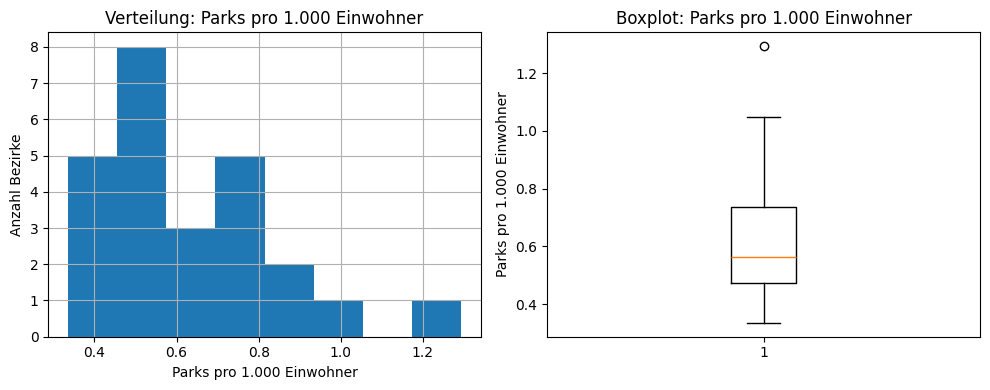

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Histogramm
gdf_active["parks_pro_1000_einw"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Anzahl Bezirke")
# Boxplot
axes[1].boxplot(gdf_active["parks_pro_1000_einw"], vert=True)
axes[1].set_title("Boxplot: Parks pro 1.000 Einwohner")
axes[1].set_ylabel("Parks pro 1.000 Einwohner")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "04_distribution_parks_pro_1000.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Der Median liegt bei **0,563 Parks pro 1.000 Einwohner** (Q1: **0,472**, Q3: **0,736**).
- Spitzenwerte erreichen **Altstadt-Lehel (1,293)** und **Trudering-Riem (1,049)**; niedrige Werte zeigen **Schwabing-West (0,335)** und **Schwanthalerhöhe (0,349)**.
- Für den Bericht: Die Streuung spricht für ungleiche wohnortnahe Parkversorgung zwischen den Bezirken.

### Anteil der Parkfläche an der Bezirksfläche

In diesem Abschnitt wird der Parkflächenanteil an der Bezirksfläche verglichen. Dadurch werden strukturelle Unterschiede der räumlichen Grünverfügbarkeit sichtbar.

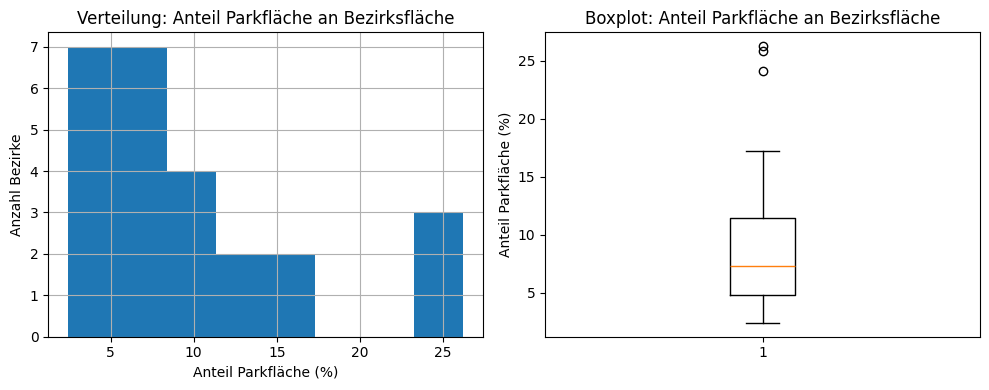

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Histogramm
gdf_active["parks_area_anteil_prozent"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Anteil Parkfläche an Bezirksfläche")
axes[0].set_xlabel("Anteil Parkfläche (%)")
axes[0].set_ylabel("Anzahl Bezirke")
# Boxplot
axes[1].boxplot(gdf_active["parks_area_anteil_prozent"], vert=True)
axes[1].set_title("Boxplot: Anteil Parkfläche an Bezirksfläche")
axes[1].set_ylabel("Anteil Parkfläche (%)")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "05_distribution_parks_area_share.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Der Median von `parks_area_anteil_prozent` liegt bei **16,45 %** (Q1: **6,45 %**, Q3: **25,02 %**).
- Hohe Werte zeigen z. B. **Altstadt-Lehel (131,2 %)** und **Maxvorstadt (98,7 %)**, niedrige Werte **Laim (2,43 %)** und **Feldmoching-Hasenbergl (2,52 %)**.
- Für den Bericht: Diese Kennzahl ergänzt die Einwohnernormierung um eine flächenstrukturelle Perspektive auf Grünverfügbarkeit.

### Ranking: Top- und Bottom-Bezirke

In diesem Abschnitt werden Top- und Bottom-Bezirke direkt gegenübergestellt. Das erleichtert die Priorisierung von Handlungsräumen im Bericht.

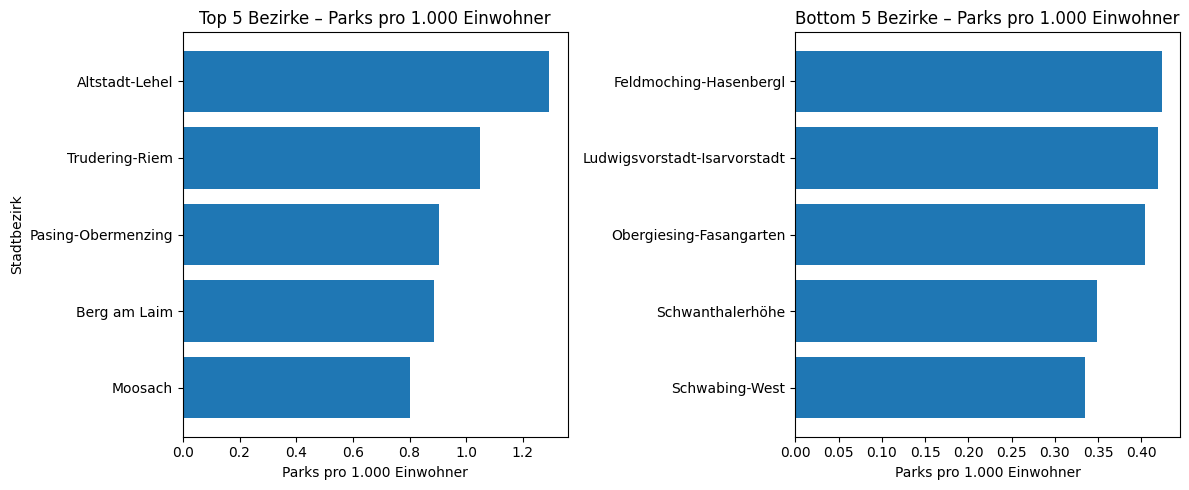

In [95]:
top5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)  # für schöne Treppe bei barh
)
bottom5 = (
    gdf_active[["name", "parks_pro_1000_einw"]]
    .sort_values("parks_pro_1000_einw", ascending=True)
    .head(5)
    .sort_values("parks_pro_1000_einw", ascending=True)
)
# Ranking-Tabellen exportieren
top5.to_csv(TABLE_DIR / "02_top5_parks_pro_1000.csv", index=False, float_format="%.4f")
bottom5.to_csv(
    TABLE_DIR / "03_bottom5_parks_pro_1000.csv", index=False, float_format="%.4f"
)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Top 5 (horizontal)
axes[0].barh(top5["name"], top5["parks_pro_1000_einw"])
axes[0].set_title("Top 5 Bezirke – Parks pro 1.000 Einwohner")
axes[0].set_xlabel("Parks pro 1.000 Einwohner")
axes[0].set_ylabel("Stadtbezirk")
# Bottom 5 (horizontal)
axes[1].barh(bottom5["name"], bottom5["parks_pro_1000_einw"])
axes[1].set_title("Bottom 5 Bezirke – Parks pro 1.000 Einwohner")
axes[1].set_xlabel("Parks pro 1.000 Einwohner")
axes[1].set_ylabel("")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "06_ranking_top_bottom_parks_pro_1000.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Im Ranking nach Parkanzahl führen **Trudering-Riem (80)**, **Neuhausen-Nymphenburg (75)** und **Pasing-Obermenzing (74)**.
- Niedrige Werte zeigen **Schwanthalerhöhe (10)**, **Sendling (19)** und **Ludwigsvorstadt-Isarvorstadt (21)**.
- Für den Bericht: Das Ranking liefert eine klare Begründung für Fokusbezirke in der weiteren Index- und Maßnahmenanalyse.

## Export

In diesem Abschnitt wird der aufbereitete Parkdatensatz für die Folgeschritte gespeichert. Damit bleibt die Pipeline reproduzierbar und als Methodik im Bericht transparent dokumentierbar.

Der Datensatz mit den parkbezogenen Kennzahlen wird als GeoJSON exportiert und steht damit direkt für die Folgeschritte (Sport, Mobilität, Gesamtindex) zur Verfügung.

In [96]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED_DIR / "muc_bezirke_parks.geojson"
gdf_active.to_file(out_path, driver="GeoJSON")
# Vollständige Park-Kennzahlen als Tabelle exportieren
gdf_active.drop(columns="geometry").to_csv(
    TABLE_DIR / "04_muc_bezirke_parks_full.csv", index=False, float_format="%.4f"
)
out_path


PosixPath('../data/processed/muc_bezirke_parks.geojson')

**Erkenntnisse:**
- Der Export stellt die reproduzierbare Übergabe in die nächsten Notebooks sicher.
- Das einheitliche GeoJSON-Format erleichtert die spätere Zusammenführung mit Sport- und Mobilitätsindikatoren.
- Für den Bericht: Der Schritt dokumentiert klar den Übergang von Datenaufbereitung zu indikatorbasierter Gesamtbewertung.